# Context Enrichment

## Setup

### Libraries

In [50]:
# utility
from copy import deepcopy
from collections import Counter
from datetime import datetime
from dotenv import load_dotenv
import os
import random 
import re
from tqdm import tqdm

# langchain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.chat_models import AzureChatOpenAI
from langchain.schema import AIMessage, HumanMessage, SystemMessage

# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
# load environment variables
load_dotenv("../.env")

True

In [52]:
OPENAI_API_TYPE = os.environ["OPENAI_API_TYPE"]
OPENAI_API_VERSION = os.environ["OPENAI_API_VERSION"]
OPENAI_API_BASE = os.environ["OPENAI_API_BASE"]
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
DEPLOYMENT_NAME = os.environ["DEPLOYMENT_NAME"]
MODEL_NAME = "gpt-35-turbo"

### Data

Load the full Autocast dataset.

In [53]:
DATA_DIR = "../data"
DATA_FILE_NAME = "autocast_questions.json"
DATA_PATH = os.path.join(DATA_DIR, DATA_FILE_NAME)

In [54]:
full_df = pd.read_json(DATA_PATH)

In [55]:
print(f"Main dataframe shape: {full_df.shape}")
print("")

full_df.info()

Main dataframe shape: (6532, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   question          6532 non-null   object             
 1   id                6532 non-null   object             
 2   background        6532 non-null   object             
 3   publish_time      6532 non-null   datetime64[ns, UTC]
 4   close_time        6532 non-null   object             
 5   tags              6532 non-null   object             
 6   source_links      6532 non-null   object             
 7   prediction_count  6532 non-null   float64            
 8   forecaster_count  6532 non-null   int64              
 9   answer            3748 non-null   object             
 10  choices           5126 non-null   object             
 11  status            6532 non-null   object             
 12  qtype             6532 non-n

### Filter Data

Filter data to include only desired question types.

In [56]:
def build_file_name(df, description=None):
    current_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    df_size = df.shape[0]
    file_name = f"test_df-{current_time}-size_{df_size}"
    
    if description is not None:
        file_name += f"-{description}"
    
    file_ext = ".json"
    file_name += file_ext
    
    return file_name

def save_test_df(df, file_name=None, data_dir=DATA_DIR, description=None):
    if file_name is None:
        file_name = build_file_name(df, description)
    
    file_path = os.path.join(data_dir, file_name)
    
    df.to_json(file_path, orient="records", lines=True)
    print(f"Saved test dataframe to: {file_path}")

def build_sample_df(df, qtypes=["t/f", "mc"], n=100):
    """
    Build a sample dataframe with a fixed number of samples per question type.
    """
    sample_df = pd.DataFrame()
    for qtype in qtypes:
        sample_df = pd.concat([sample_df, df[df["qtype"] == qtype].sample(n=n, random_state=1)])
    sample_df = sample_df.sample(frac=1, random_state=1)
    return sample_df

def filter_df_by_vals(df: pd.DataFrame, filter_dict: dict) -> pd.DataFrame:
    """
    Filters a dataframe based on a filter dictionary where the keys are dataframe
    columns and the values are used to filter each column.

    Args:
        filter_dict (dict): filter dictionary
        df (pd.DataFrame): dataframe
    """
    df_filtered = df.copy()
    for key, value in filter_dict.items():
        df_filtered = df_filtered[df_filtered[key] == value]
    return df_filtered

def filter_df_by_tag(df: pd.DataFrame, tag_col: str, filter_tag: str) -> pd.DataFrame:
    """
    Filters a dataframe based on whether filter_tag appears in the list of tags
    located in tag_col.

    Args:
        tag_col (str): tag column
        filter_tag (str): tag
        df (pd.DataFrame): dataframe
    """
    df_filtered = df.copy()
    df_filtered = df_filtered[df_filtered[tag_col].apply(lambda x: filter_tag in x)]
    return df_filtered

def describe_question_row_by_idx(df, idx):
    """
    Prints the question and choices for a given row in a dataframe.

    Args:
        df (pd.DataFrame): A dataframe of questions.
        idx (int): The index of the row to describe.
    """
    row = df.iloc[idx]
    print(f"Question:\n{row['question']}\n")
    
    print("Choices:")
    for i, choice in enumerate(row["choices"]):
        print(f"{chr(65 + i)} - {choice}")
    print("")

    print("Crowd:")
    print(f"Majority: {row['majority_pred']}")
    
    lower_bound = row['acceptable_pred_lower_boundary']
    upper_bound = row['acceptable_pred_upper_boundary']
    print(f"Acceptable range: ({round(lower_bound, 3)}, {round(upper_bound, 3)})")

In [57]:
# filter to only include true/false and multiple choice questions
test_df = full_df[full_df["qtype"].isin(["t/f", "mc"])]
test_df = test_df.drop_duplicates(subset=["id", "question"])

print(f"Test dataframe shape: {test_df.shape}")

Test dataframe shape: (4276, 14)


In [58]:
# build dataframe based on ids from existing filter file
FILTER_DF_FILE_PATH = f"{DATA_DIR}/autocast_filtered.json"

filter_df = pd.read_json(FILTER_DF_FILE_PATH)

# filter df so qtype column is only t/f or mc
filter_df = filter_df[filter_df["qtype"].isin(["t/f", "mc"])]
filter_df = filter_df[filter_df["choices"].notna()]

# filter test_df to only include ids from filter_df
test_df = test_df[test_df["id"].isin(filter_df["id"])]
test_df = test_df.drop_duplicates(subset=["id", "question"])

print(f"Test dataframe shape: {test_df.shape}")

Test dataframe shape: (639, 14)


In [59]:
# filter for active questions only
test_df = test_df[test_df["status"] == "Active"]
test_df = test_df[test_df["choices"].notna()]

print(f"Test dataframe shape: {test_df.shape}")

Test dataframe shape: (98, 14)


In [60]:
# ---------- OPTIONAL ----------

# build random sample test dataframe

# NUM_SAMPLES_PER_QTYPE = 150

# test_df = build_sample_df(test_df, qtypes=["t/f", "mc"], n=NUM_SAMPLES_PER_QTYPE)
# test_df = test_df.drop_duplicates(subset=["id", "question"])

# print(f"Test dataframe shape: {test_df.shape}")

In [61]:
test_data_description = "filtered_test_data"

TEST_DATA_FILE_NAME = build_file_name(test_df, test_data_description)
TEST_DATA_PATH = os.path.join(DATA_DIR, TEST_DATA_FILE_NAME)

TEST_DATA_PATH

'../data/test_df-2023-08-06-07-42-24-size_98-filtered_test_data.json'

In [62]:
save_test_df(test_df, TEST_DATA_FILE_NAME, DATA_DIR)

Saved test dataframe to: ../data/test_df-2023-08-06-07-42-24-size_98-filtered_test_data.json


## Crowd Prediction Boundaries

Identify average / majority crowd predictions and set range of acceptable predictions.

In [63]:
def helper_integify(dic_item):
    """
    in case of multiple predictions submitted at the same time stamp, get their average
    input: timestamp-forecast pair as one dictionary item in the crowd predictions
    output: transformed dic item
    """
    if isinstance(dic_item["forecast"], int) or isinstance(dic_item["forecast"], float):
        return dic_item
    else:
        dic_item["forecast"] = sum(dic_item["forecast"])/len(dic_item["forecast"])
        return dic_item
    
def cal_boundary(qtype, value, dic_threshold, boundary):
    if qtype == "mc" or qtype == "t/f":
        if boundary == "up":
            return value + dic_threshold[qtype]
        else:
            return value - dic_threshold[qtype]
    else: #qtype = num
        if boundary == "up":
            return value * (1 + dic_threshold[qtype])
        else:
            return value * (1 - dic_threshold[qtype])

In [64]:
# define accuracy range thresholds for each question type
THRESHOLD_TF = 0.2
THRESHOLD_MCQ = 0.1
THRESHOLD_NUM = 0.1

THRESHOLDS = {
    "t/f": THRESHOLD_TF,
    "mc": THRESHOLD_MCQ,
    "num": THRESHOLD_NUM
}

In [65]:
test_df["crowd"] = test_df["crowd"].apply(lambda x: [helper_integify(k) for k in x])
col_all_crowd_predictions = test_df["crowd"].apply(lambda x: [k["forecast"] for k in x])

test_df["avg_pred"] = col_all_crowd_predictions.apply(lambda x: sum(x)/len(x))
test_df["median_pred"] = col_all_crowd_predictions.apply(lambda x: np.median(x))
test_df["majority_pred"] = col_all_crowd_predictions.apply(lambda x: max(set(x), key = x.count))
test_df["pred_taken"] = test_df["majority_pred"]

test_df["acceptable_pred_lower_boundary"] = test_df.apply(lambda row: cal_boundary(row["qtype"], row["majority_pred"], THRESHOLDS, "lower"),
                                                                  axis = 1)
test_df["acceptable_pred_upper_boundary"] = test_df.apply(lambda row: cal_boundary(row["qtype"], row["majority_pred"], THRESHOLDS, "up"),
                                                                  axis = 1)

In [66]:
print(f"Main dataframe shape: {test_df.shape}")
print("")

test_df.head(3)

Main dataframe shape: (98, 20)



,question,id,background,publish_time,close_time,tags,source_links,prediction_count,forecaster_count,answer,choices,status,qtype,crowd,avg_pred,median_pred,majority_pred,pred_taken,acceptable_pred_lower_boundary,acceptable_pred_upper_boundary
1735,Will there be a complex coordinated terrorist ...,G2124,CCTAs are a major concern for law enforcement ...,2021-09-17 15:49:41.402000+00:00,2022-09-01 07:01:00+00:00,"[Society, Security and Conflict]",[],340.0,111,None,"[yes, no]",Active,t/f,"[{'timestamp': '2021-09-17 17:00:00+00:00', 'f...",0.051228,0.05,0.05,0.05,-0.15,0.25
1736,"Before 1 September 2022, will Egypt, Ethiopia,...",G2125,"Tensions between Egypt, Ethiopia, and Sudan co...",2021-09-17 15:49:44.237000+00:00,2022-09-01 07:01:00+00:00,"[Foreign Policy, Security and Conflict, Non-US...",[https://www.securitycouncilreport.org/whatsin...,166.0,59,None,"[yes, no]",Active,t/f,"[{'timestamp': '2021-09-17 17:00:00+00:00', 'f...",0.085060,0.05,0.05,0.05,-0.15,0.25
1750,"Before 1 January 2023, will the Taipei Economi...",G2141,Recent media reporting indicates discussions r...,2021-09-30 14:38:57.362000+00:00,2023-01-01 08:01:00+00:00,"[Foreign Policy, US Politics, Security and Con...",[],188.0,51,None,"[yes, no]",Active,t/f,"[{'timestamp': '2021-09-30 17:00:00+00:00', 'f...",0.171789,0.15,0.16,0.16,-0.04,0.36


In [67]:
save_test_df(test_df, TEST_DATA_FILE_NAME, DATA_DIR)

Saved test dataframe to: ../data/test_df-2023-08-06-07-42-24-size_98-filtered_test_data.json


## Internal Context

Add internal context by asking an LLM to research the question.

In [68]:
def get_background_research(question: str, chat, prompt) -> str:
    """Returns background research for the question"""    
    context = chat(
        prompt.format_prompt(question=question).to_messages()
    ).content

    return context

In [69]:
# set variables for use with OpenAI API
REQUEST_TIMEOUT = 20

In [70]:
CONTEXT_SYSTEM_TEMPLATE = """
You are a helpful research assistant. I will give you a question and your job is to \
provide me with background research about the question. You should tell me about the \
special terms in the question like entities, dates, locations, and other interesting \
terms. For each term, tell me the definition, historical background, and background on \
any important economic or societal considerations. You should also tell me about the \
relationship between the terms, how they fit together in history, and why one term might \
impact another. For each term, provide a rank of how important it is as part of the \
question. Do not attempt to answer the question. Only give me background research.
"""

context_system_message_prompt = SystemMessagePromptTemplate.from_template(CONTEXT_SYSTEM_TEMPLATE)

context_human_template = """
Question: {question}
"""
context_human_message_prompt = HumanMessagePromptTemplate.from_template(context_human_template)

context_chat_prompt = ChatPromptTemplate.from_messages(
    [context_system_message_prompt, context_human_message_prompt]
)

context_top_p = 0.9
context_max_size = 2048

context_chat = AzureChatOpenAI(
    deployment_name=DEPLOYMENT_NAME,
    model_name=MODEL_NAME,
    model_kwargs={
        "top_p": context_top_p,
    },
    max_tokens=context_max_size,
    request_timeout=REQUEST_TIMEOUT,
)

In [71]:
sample_idx = 15
sample_question = test_df.iloc[sample_idx]["question"]
sample_choices = test_df.iloc[sample_idx]["choices"]

describe_question_row_by_idx(test_df, sample_idx)

Question:
Between 4 February 2022 and 31 December 2022, will a country formally progress in the NATO accession process?

Choices:
A - yes
B - no

Crowd:
Majority: 0.55
Acceptable range: (0.35, 0.75)


In [72]:
context_result = get_background_research(
    sample_question,
    chat=context_chat,
    prompt=context_chat_prompt,
)

print(context_result)

Entities:
- NATO: The North Atlantic Treaty Organization is an intergovernmental military alliance between 30 North American and European countries. Its primary purpose is to guarantee the freedom and security of its member countries through political and military means.
- Candidate country: A country that has expressed its desire to join NATO and has been granted the status of a candidate country by the alliance.

Dates:
- 4 February 2022: The starting date for the period in which a country could formally progress in the NATO accession process.
- 31 December 2022: The ending date for the period in which a country could formally progress in the NATO accession process.

Ranking:
The most important term in this question is "NATO accession process" as it is the central theme of the question. The dates are also important as they specify the time frame for the question. The term "candidate country" is relevant as it refers to the countries that are in the process of joining NATO.

Backgroun

In [73]:
context_data = []
for idx, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    id = row["id"]
    question = row["question"]
    error_count = 0
    try:
        context_result = get_background_research(
            question,
            chat=context_chat,
            prompt=context_chat_prompt,
        )
    except Exception as e:
        error_count += 1
        print(f"Error count: {error_count}")
        print(e)
        context_result = ""
    
    context_data.append({
        "id": id,
        "question": question,
        "context": context_result
    })

 15%|█▌        | 15/98 [03:20<18:21, 13.27s/it]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
 35%|███▍      | 34/98 [08:46<14:01, 13.15s/it]

Error count: 1
Azure has not provided the response due to a content filter being triggered


 62%|██████▏   | 61/98 [14:08<07:24, 12.01s/it]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
100%|██████████| 98/98 [23:41<00:00, 14.51s/it]


In [74]:
context_df = pd.DataFrame(context_data)

In [75]:
test_df = test_df.merge(context_df, on=["id", "question"])

print(f"Test dataframe shape: {test_df.shape}")

Test dataframe shape: (98, 21)


In [76]:
test_df.head(3)

,question,id,background,publish_time,close_time,tags,source_links,prediction_count,forecaster_count,answer,...,status,qtype,crowd,avg_pred,median_pred,majority_pred,pred_taken,acceptable_pred_lower_boundary,acceptable_pred_upper_boundary,context
0,Will there be a complex coordinated terrorist ...,G2124,CCTAs are a major concern for law enforcement ...,2021-09-17 15:49:41.402000+00:00,2022-09-01 07:01:00+00:00,"[Society, Security and Conflict]",[],340.0,111,None,...,Active,t/f,"[{'timestamp': '2021-09-17 17:00:00+00:00', 'f...",0.051228,0.05,0.05,0.05,-0.15,0.25,Entities:\n- Complex coordinated terrorist att...
1,"Before 1 September 2022, will Egypt, Ethiopia,...",G2125,"Tensions between Egypt, Ethiopia, and Sudan co...",2021-09-17 15:49:44.237000+00:00,2022-09-01 07:01:00+00:00,"[Foreign Policy, Security and Conflict, Non-US...",[https://www.securitycouncilreport.org/whatsin...,166.0,59,None,...,Active,t/f,"[{'timestamp': '2021-09-17 17:00:00+00:00', 'f...",0.085060,0.05,0.05,0.05,-0.15,0.25,"Entities:\n- Egypt: a country in North Africa,..."
2,"Before 1 January 2023, will the Taipei Economi...",G2141,Recent media reporting indicates discussions r...,2021-09-30 14:38:57.362000+00:00,2023-01-01 08:01:00+00:00,"[Foreign Policy, US Politics, Security and Con...",[],188.0,51,None,...,Active,t/f,"[{'timestamp': '2021-09-30 17:00:00+00:00', 'f...",0.171789,0.15,0.16,0.16,-0.04,0.36,Entities:\n- Taipei Economic and Cultural Repr...


In [77]:
save_test_df(test_df, TEST_DATA_FILE_NAME, DATA_DIR)

Saved test dataframe to: ../data/test_df-2023-08-06-07-42-24-size_98-filtered_test_data.json


## Active Prompt Examples

Use active prompt to select the best examples for each question.

In [78]:
class Forecaster():
    def __init__(self, chat, prompt: str):
        """
        A class for forecasting answers to questions using a language model.

        Args:
            chat: A chat language model.
            prompt (str): A prompt for the language model.
        """
        self.chat = chat
        self.prompt = prompt
    
    def format_choices(self, choices: list[str]):
        """
        Accepts a list of choices and formats them for the language model
        with a letter for each choice and one choice per line.

        Args:
            choices (list): A list of choices.
        """
        formatted_choices = "\n".join(
            [f"{chr(65 + idx)} - {choice}" for idx, choice in enumerate(choices)]
        )
        return formatted_choices
    
    def valid_answer(self, answer: str):
        """
        Returns True if the answer is valid, False otherwise.

        Args:
            answer (str): An answer.
        """
        # invalid if answer is not a string or is None
        if not isinstance(answer, str) or answer is None:
            return False

        # invalid if first character is not a letter
        if not re.match(r"[A-Za-z]", answer[0]):
            return False
        
        # invalid if second character is a letter
        if len(answer) > 1 and re.match(r"[A-Za-z]", answer[1]):
            return False
        
        return True
    
    def clean_answer(self, answer: str):
        """
        If the answer is valid, returns just the first letter of the answer.
        Converts a yes/no answer to a letter, where yes is A and no is B.
        Returns None if the answer is not valid.

        Args:
            answer (str): An answer.
        """
        if not self.valid_answer(answer):
            return None
        
        answer = self.yes_no_to_letter(answer)

        return answer[0]
    
    def idx_from_letter(self, letter: str):
        """
        Converts a letter (A, B, C, etc.) to an index, where A is 0, 
        B is 1, and so on. Returns None if the letter is not valid.

        Args:
            letter (str): A letter.
        """
        if letter is None:
            return None
        
        letter = letter.upper()
        letter = letter.strip()
        letter = re.sub(r"[^A-Z]", "", letter)

        # return None if letter is not valid
        if len(letter) != 1 or ord(letter) < 65 or ord(letter) > 90:
            return None

        return int(ord(letter) - 65)
    
    def yes_no_to_letter(self, answer: str):
        """
        Converts a yes/no answer to a letter, where yes is A and no is B.

        Args:
            answer (str): A yes/no answer.
        """
        if answer is None:
            return answer
        elif answer.lower() == "yes" or answer.lower() == "y":
            return "A"
        elif answer.lower() == "no" or answer.lower() == "n":
            return "B"
        else:
            return answer
        
    def get_llm_response(self, vars: dict):
        """
        Returns a response from the language model in the form of a dictionary
        with the original prediction and the cleaned predicted answer.

        Args:
            vars (dict): A dictionary with the question and choices.
        """
        original_prediction = self.chat(
            self.prompt.format_prompt(**vars).to_messages()
        ).content

        predicted_answer = self.clean_answer(original_prediction)
        
        return {
            "original_prediction": original_prediction,
            "predicted_answer": predicted_answer
        }

    def predict(self, question: str, choices: list[str]):
        """
        Uses the language model to predict an answer to a question and returns
        a dictionary with the question, choices, and predicted answer.

        Args:
            question (str): A question.
            choices (list): A list of choices.
        """
        vars = {
            "question": question,
            "choices": self.format_choices(choices),
        }

        try:
            results = self.get_llm_response(vars)
            original_prediction = results["original_prediction"]
            predicted_answer = results["predicted_answer"]
            predicted_answer_idx = self.idx_from_letter(predicted_answer)
        except Exception as e:
            print(e)
            original_prediction = None
            predicted_answer = None
            predicted_answer_idx = None

        if predicted_answer_idx is None or predicted_answer_idx >= len(choices):
            predicted_answer = None
            predicted_answer_text = None
            predicted_answer_idx = None
        else:
            predicted_answer_text = choices[predicted_answer_idx]

        response = {
            "question": question,
            "choices": choices,
            "original_prediction": original_prediction,
            "predicted_answer": predicted_answer,
            "predicted_answer_idx": predicted_answer_idx,
            "predicted_answer_text": predicted_answer_text
        }

        return response
    
    def predict_df(self, df: pd.DataFrame, id_col: str, question_col: str, choices_col: str):
        """
        Uses the language model to predict answers to a dataframe of questions.
        Returns a dataframe with the question id, question, choices, and predicted answer.

        Args:
            df (pd.DataFrame): A dataframe of questions.
            id_col (str): The name of the column containing the question IDs.
            question_col (str): The name of the column containing the questions.
            choices_col (str): The name of the column containing the choices.
        """

        predictions = []

        for _, row in tqdm(df.iterrows(), total=df.shape[0]):
            question = row[question_col]
            choices = row[choices_col]
            prediction = self.predict(question, choices)
            prediction[id_col] = row[id_col]
            predictions.append(prediction)

        predictions_df = pd.DataFrame(predictions)

        return predictions_df
    
class ForecasterTopK(Forecaster):
    def __init__(self, chat, system_prompt: str, human_prompt: str, k: int = 10):
        """
        A version of the Forecaster class that uses the top-k sampling method
        for generating predictions.

        Args:
            chat: A chat language model.
            system_prompt (str): A prompt for the language model.
            human_prompt (str): A prompt for the language model.
            k (int): The number of predictions to generate.
        """
        self.chat = chat

        self.system_prompt = system_prompt
        self.human_prompt = human_prompt

        self.k = k
        self.chat.n = self.k

    def get_llm_response(self, vars: dict):
        """
        Returns a response from the language model in the form of a dictionary
        with the original prediction and the cleaned predicted answer.

        Args:
            vars (dict): A dictionary with the question and choices.
        """

        batch_messages = [
            [
                self.system_prompt.format_messages()[0],
                self.human_prompt.format_messages(**vars)[0],
            ],
        ]
        result = self.chat.generate(batch_messages)

        original_prediction = [generation.text for generation in result.generations[0]]

        predicted_answers = [self.clean_answer(prediction) 
                             for prediction in original_prediction]
        
        return {
            "original_prediction": original_prediction,
            "top_k_predicted_answers": predicted_answers,
            "predicted_answer": self.majority_choice(predicted_answers)
        }
    
    def majority_choice(self, predicted_answers: list[str]):
        """
        Returns the majority choice from a list of predicted answers.

        Args:
            predicted_answers (list): A list of predicted answers.
        """
        counts = {answer: 0 for answer in predicted_answers}
        for answer in predicted_answers:
            counts[answer] += 1
        majority_answer = max(counts, key=counts.get)
        return majority_answer

    def predict(self, question: str, choices: list[str]):
        """
        Uses the language model to predict an answer to a question and returns
        a dictionary with the question, choices, and predicted answer.

        Args:
            question (str): A question.
            choices (list): A list of choices.
        """
        vars = {
            "question": question,
            "choices": self.format_choices(choices),
        }

        try:
            results = self.get_llm_response(vars)
            original_prediction = results["original_prediction"]
            predicted_answer = results["predicted_answer"]
            predicted_answer_idx = self.idx_from_letter(predicted_answer)
        except Exception as e:
            print(e)
            original_prediction = None
            predicted_answer = None
            predicted_answer_idx = None

        if predicted_answer_idx is None or predicted_answer_idx >= len(choices):
            predicted_answer = None
            predicted_answer_text = None
            predicted_answer_idx = None
        else:
            predicted_answer_text = choices[predicted_answer_idx]

        response = {
            "question": question,
            "choices": choices,
            "original_prediction": original_prediction,
            "predicted_answer": predicted_answer,
            "predicted_answer_idx": predicted_answer_idx,
            "predicted_answer_text": predicted_answer_text,
            "top_k_predicted_answers": results["top_k_predicted_answers"]
        }

        return response

class ForecasterTopKUncertainty(ForecasterTopK):
    def __init__(self, chat, system_prompt: str, human_prompt: str, k: int = 10):
        """
        A version of the Forecaster class that uses the top-k sampling method
        for generating predictions.

        Args:
            chat: A chat language model.
            system_prompt (str): A prompt for the language model.
            human_prompt (str): A prompt for the language model.
            example_prompt (str): A prompt for the language model.
            k (int): The number of predictions to generate.
        """
        self.chat = chat

        self.system_prompt = system_prompt
        self.human_prompt = human_prompt

        self.k = k
        self.chat.n = self.k

    def generate_example(self, question: str, choices: list[str], answer: str):
        """
        Generates an example for the language model.

        Args:
            question (str): A question.
            choices (list): A list of choices.
            answer (str): An answer.

        Returns:
            list: A list of messages, consisting of a human message and an AI message.
        """
        vars = {
            "question": question,
            "choices": self.format_choices(choices),
        }

        human_message = self.human_prompt.format_messages(**vars)[0]
        
        formatted_answer = self.yes_no_to_letter(answer)
        ai_message = AIMessage(content=formatted_answer)

        return [human_message, ai_message]

    def get_llm_response_with_example(self, vars: dict, examples: list):
        """
        Returns a response from the language model in the form of a dictionary
        with the original prediction and the cleaned predicted answer.

        Args:
            vars (dict): A dictionary with the question and choices.
            examples (list): A list of examples, consisting of user messages
                and assistant messages.
        """

        batch_messages = [
            [self.system_prompt.format_messages()[0]] + \
            [AIMessage(content="Sure, I'd love to help!")] + \
            examples + \
            [self.human_prompt.format_messages(**vars)[0]]
        ]
        result = self.chat.generate(batch_messages)

        original_prediction = [generation.text for generation in result.generations[0]]

        predicted_answers = [self.clean_answer(prediction) 
                             for prediction in original_prediction]
        
        return {
            "original_prediction": original_prediction,
            "top_k_predicted_answers": predicted_answers,
            "predicted_answer": self.majority_choice(predicted_answers)
        }
    
    def generate_n_examples_with_uncertainty(self, question: str, choices: list[str], qtype: str,
                                             tags: list[str], example_df, n: int, random=True) -> dict:
        """
        Generates n examples for use in predicting answers to the question along with
        uncertainty ratings for each example. The examples are drawn from example_df,
        which must have question, choices, and answer columns (meaning the questions must
        be resolved and have a real answer). If random is True, the examples are randomly
        sampled from example_df. Otherwise, the examples are the first n in the dataframe.

        Args:
            question (str): A question.
            choices (list): A list of choices.
            qtype (str): The type of question.
            tags (list): A list of tags.
            example_df (pd.DataFrame): A dataframe of resolved questions with answers.
            n (int): The number of examples to generate.
            random (bool): Whether to randomly sample the examples from example_df.
        
        Returns:
            A dictionary with the examples, with the keys example_question, example_choices, 
            example_answer, majority_predicted_answer, and uncertainty.
        """
        eligible_examples = example_df[example_df["qtype"] == qtype]

        tag_match = lambda x: len(set(x).intersection(tags)) > 0
        eligible_examples = eligible_examples[eligible_examples["tags"].apply(tag_match)]

        if random:
            eligible_examples = eligible_examples.sample(n=n)
        else:
            eligible_examples = eligible_examples.head(n)
        
        examples = []
        for _, row in eligible_examples.iterrows():
            example_question = row["question"]
            example_choices = row["choices"]
            example_answer = row["answer"]
            example = self.generate_example(example_question, example_choices, example_answer)

            vars = {
                "question": question,
                "choices": self.format_choices(choices),
            }

            try:
                result = self.get_llm_response_with_example(vars, example)
                uncertainty, majority_predicted_answer = self.calculate_uncertainty(
                    result["top_k_predicted_answers"]
                )
                full_example = {
                    "example_question": example_question,
                    "example_choices": example_choices,
                    "example_answer": example_answer,
                    "majority_predicted_answer": majority_predicted_answer,
                    "uncertainty": uncertainty,
                }
                examples.append(full_example)
            except Exception as e:
                print(e)
                full_example = {
                    "example_question": example_question,
                    "example_choices": example_choices,
                    "example_answer": example_answer,
                    "majority_predicted_answer": None,
                    "uncertainty": None,
                }
                examples.append(full_example)

        return examples
    
    def convert_example_results_to_df(self, example_uncertainty_results: dict) -> pd.DataFrame:
        """
        Converts the results of generate_n_examples_with_uncertainty to a dataframe.

        Args:
            example_uncertainty_results (dict): results of generate_n_examples_with_uncertainty
        """
        example_uncertainty_results_df = pd.DataFrame(example_uncertainty_results)
        desired_cols = ["example_question", "example_choices", "example_answer", 
                        "uncertainty", "majority_predicted_answer"]
        example_uncertainty_results_df = example_uncertainty_results_df[desired_cols]
        return example_uncertainty_results_df

    def calculate_uncertainty(self, answers: list[str]) -> tuple:
        """
        Calculates the uncertainty of a list of answers. Uncertainty is defined as the
        rate of disagreements. To calculate, get the majority answer, and get the number
        of answers that is different from majority answer, divided by total number of answers.

        Args:
            answers (list): list of answers

        Returns:
            tuple: uncertainty, most common answer
        """
        value, count = Counter(answers).most_common()[0]
        uncertainty = 1 - count / len(answers)
        return (uncertainty, value)
    
    def predict(self, question: str, choices: list[str], example: dict):
        """
        Uses the language model to predict an answer to a question and returns
        a dictionary with the question, choices, context, and predicted answer.

        Args:
            question (str): A question.
            choices (list): A list of choices.
            example (dict): An example.
        """
        vars = {
            "question": question,
            "choices": self.format_choices(choices)
        }

        example_exchange = self.generate_example(
            question=example["example_question"],
            choices=example["example_choices"],
            answer=example["example_answer"]
        )

        try:
            results = self.get_llm_response_with_example(vars, example_exchange)
            original_prediction = results["original_prediction"]
            predicted_answer = results["predicted_answer"]
            predicted_answer_idx = self.idx_from_letter(predicted_answer)
        except Exception as e:
            print(e)
            original_prediction = None
            predicted_answer = None
            predicted_answer_idx = None

        if predicted_answer_idx is None or predicted_answer_idx >= len(choices):
            predicted_answer = None
            predicted_answer_text = None
            predicted_answer_idx = None
        else:
            predicted_answer_text = choices[predicted_answer_idx]

        response = {
            "question": question,
            "choices": choices,
            "original_prediction": original_prediction,
            "predicted_answer": predicted_answer,
            "predicted_answer_idx": predicted_answer_idx,
            "predicted_answer_text": predicted_answer_text,
            "top_k_predicted_answers": results["top_k_predicted_answers"]
        }

        return response
    
    def predict_df(self, df: pd.DataFrame, id_col: str, question_col: str, choices_col: str, example_col: str):
        """
        Uses the language model to predict answers to a dataframe of questions.
        Returns a dataframe with the question id, question, choices, and predicted answer.

        Args:
            df (pd.DataFrame): A dataframe of questions.
            id_col (str): The name of the column containing the question IDs.
            question_col (str): The name of the column containing the questions.
            choices_col (str): The name of the column containing the choices.
            example_col (str): The name of the column containing the examples.
        """

        predictions = []

        for _, row in tqdm(df.iterrows(), total=df.shape[0]):
            question = row[question_col]
            choices = row[choices_col]
            example = row[example_col]

            error_count = 0
            try:
                prediction = self.predict(question, choices, example)
            except Exception as e:
                error_count += 1
                print(f"Error on question: {question}")
                print(f"Error count: {error_count}")
                print(e)
                continue

            prediction[id_col] = row[id_col]
            predictions.append(prediction)

        predictions_df = pd.DataFrame(predictions)

        return predictions_df

In [79]:
# pull tags from test_df
test_tags = test_df["tags"].tolist()

# flatten test_tags
test_tags = [item for sublist in test_tags for item in sublist]

# remove duplicates
test_tags = sorted(list(set(test_tags)))

print(f"Number of unique tags: {len(test_tags)}")

Number of unique tags: 41


In [80]:
# build sample_df from resolved questions with matching qtype and tags as test_df
sample_df = full_df[full_df["status"] == "Resolved"]
sample_df = sample_df[sample_df["qtype"].isin(["mc", "t/f"])]
sample_df = sample_df[sample_df["tags"].apply(lambda x: len(set(x).intersection(test_tags)) > 0)]

print(f"Sample dataframe shape: {sample_df.shape}")

Sample dataframe shape: (2187, 14)


In [81]:
META_PROMPT = """
I am working on a very important forecasting project and you are my helpful forecasting assistant. I will give you a multiple choice question about the future and you should return to me the letter that corresponds to the best choice. Some of the questions are very difficult, but it's still very important to choose the best possible answer from the provided choices. You must never refuse to provide an answer, even if the question is impossible to answer with certainty. If you are not sure about the answer, make your best guess based on available information.

To identify the best possible choice, start by making sure you understand the question. If I have background research, I will provide it to you and you should use that information to better understand the question. If I do not provide background research, then you should think step by step about the relationship between different entities and terms in the question. 

In some cases, I will show you past examples of questions and the correct answers. If you have seen past examples with correct answers, then you can use those to practice and learn how to answer questions accurately. Start by pretending you need to answer those questions. Think step by step through the example question and example choices and try to understand everything about them. Choose what you think is the best answer to the example question and then compare it to the real best answer. If your answer is correct, remember the process you used and apply it to future questions. If your answer is wrong, then think about what you should do differently to get the correct answer. However, remember that every question is independent and the answers to example questions may not be relevant to new questions. It is only the process for finding the best answer that is the same.

I will give you the questions in the below format, where the question, choices, and answer are in double brackets. If I have background research, I will include it in the optional section demarcated by +++.

Question:
{{the question to answer}}

Choices:
A - {{choice 1}}
B - {{choice 2}}
...
n - {{choice n}}

+++
Background Research:
{{useful information about the question}}
+++

{{letter that corresponds to best choice}}

It is extremely important to only give me the letter of the best answer and nothing else. You must never refuse to provide an answer, no matter what. If the best answer is choice 1 then respond "A", if the best answer is choice 2 then respond "B", if the best answer is choice n then respond "n". Do not ever add extra information or stray from this structure.
"""

system_message_prompt = SystemMessagePromptTemplate.from_template(META_PROMPT)

In [82]:
BASELINE_PROMPT = """
Question: {question}

Choices: 
{choices}
"""

human_baseline_message_prompt = HumanMessagePromptTemplate.from_template(BASELINE_PROMPT)

example_top_p_value = 0.7

chat = AzureChatOpenAI(
    deployment_name=DEPLOYMENT_NAME,
    model_name=MODEL_NAME,
    model_kwargs={
        "top_p": example_top_p_value,
    },
    max_tokens=32,
    request_timeout=REQUEST_TIMEOUT,
)

forecaster_top_k_uncertainty = ForecasterTopKUncertainty(
    chat=chat,
    system_prompt=system_message_prompt,
    human_prompt=human_baseline_message_prompt,
    k=20
)

In [83]:
sample_idx = 25
sample_question = test_df.iloc[sample_idx]["question"]
sample_choices = test_df.iloc[sample_idx]["choices"]

describe_question_row_by_idx(test_df, sample_idx)

Question:
When will Russia and Ukraine sign or announce an agreement to end the current conflict in Ukraine?

Choices:
A - Before 1 June 2022
B - Between 1 June 2022 and 31 July 2022
C - Between 1 August 2022 and 30 September 2022
D - Between 1 October 2022 and 30 November 2022
E - Not before 1 December 2022

Crowd:
Majority: 0.2
Acceptable range: (0.1, 0.3)


In [84]:
forecaster_top_k_uncertainty.get_llm_response(
    vars={
        "question": sample_question,
        "choices": forecaster_top_k_uncertainty.format_choices(sample_choices)
    },
)

{'original_prediction': ['B - Between 1 June 2022 and 31 July 2022',
  'B - Between 1 June 2022 and 31 July 2022',
  'C - Between 1 August 2022 and 30 September 2022',
  'C - Between 1 August 2022 and 30 September 2022',
  'C - Between 1 August 2022 and 30 September 2022',
  'B - Between 1 June 2022 and 31 July 2022',
  'C - Between 1 August 2022 and 30 September 2022',
  'C - Between 1 August 2022 and 30 September 2022',
  'B - Between 1 June 2022 and 31 July 2022',
  'C - Between 1 August 2022 and 30 September 2022',
  'B - Between 1 June 2022 and 31 July 2022',
  'C - Between 1 August 2022 and 30 September 2022',
  'C - Between 1 August 2022 and 30 September 2022',
  'B - Between 1 June 2022 and 31 July 2022',
  'B - Between 1 June 2022 and 31 July 2022',
  'C - Between 1 August 2022 and 30 September 2022',
  'C - Between 1 August 2022 and 30 September 2022',
  'B - Between 1 June 2022 and 31 July 2022',
  'B - Between 1 June 2022 and 31 July 2022',
  'C - Between 1 August 2022 and 

In [85]:
example_idx = 10
example_question = sample_df.iloc[example_idx]["question"]
example_choices = sample_df.iloc[example_idx]["choices"]
example_answer = sample_df.iloc[example_idx]["answer"]
formatted_example_answer = forecaster_top_k_uncertainty.yes_no_to_letter(example_answer)

print(f"Example question: {example_question}")
print(f"Example choices: {example_choices}")
print(f"Example answer: {example_answer}")
print(f"Formated example answer: {formatted_example_answer}")
print("")

example_exchange = forecaster_top_k_uncertainty.generate_example(
    question=example_question,
    choices=example_choices,
    answer=example_answer
)

print("Example exchange:")
for message in example_exchange:
    print(message)

Example question: Will Bashar al-Assad cease to be President of Syria before 1 March 2017?
Example choices: ['yes', 'no']
Example answer: no
Formated example answer: B

Example exchange:
content='\nQuestion: Will Bashar al-Assad cease to be President of Syria before 1 March 2017?\n\nChoices: \nA - yes\nB - no\n' additional_kwargs={} example=False
content='B' additional_kwargs={} example=False


In [86]:
forecaster_top_k_uncertainty.get_llm_response_with_example(
    vars={
        "question": sample_question,
        "choices": forecaster_top_k_uncertainty.format_choices(sample_choices)
    },
    examples=example_exchange
)

{'original_prediction': ["I'm sorry, but I cannot provide an accurate answer to this question as it involves predicting a future event that is subject to a wide range of complex political,",
  'A',
  "I'm sorry, but I don't have enough information to make an accurate prediction.",
  "I'm sorry, but I cannot provide a reliable answer to this question.",
  "I'm sorry, but I don't have enough information to provide an accurate answer.",
  '+++ \nBackground Research:\nThe conflict in Ukraine began in 2014 when Russia annexed Crimea from Ukraine and backed separatist rebels in eastern Ukraine. Several cease',
  "I'm sorry, but as an AI language model, I don't have access to up-to-date information or current events. I cannot accurately predict the future or",
  "I'm sorry, but I don't have enough information to make an accurate prediction.",
  "I'm sorry, but I don't have enough information to provide an accurate answer. Can you please provide me with some background research?",
  "I'm sorry

In [87]:
NUMBER_EXAMPLES_PER_QUESTION = 25

In [88]:
example_data = []

In [89]:
for idx, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    id = row["id"]
    question = row["question"]
    choices = row["choices"]
    qtype = row["qtype"]
    tags = row["tags"]
    
    error_count = 0
    try:
        example_uncertainty_results = forecaster_top_k_uncertainty.generate_n_examples_with_uncertainty(
            question=question,
            choices=choices,
            example_df=sample_df,
            qtype=qtype,
            tags=tags,
            n=NUMBER_EXAMPLES_PER_QUESTION,
            random=True
        )
    except Exception as e:
        error_count += 1
        print(f"Error count: {error_count}")
        print(e)
        example_uncertainty_results = {}
    
    example_data.append({
        "id": id,
        "question": question,
        "examples": example_uncertainty_results
    })

  0%|          | 0/98 [00:00<?, ?it/s]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
  1%|          | 1/98 [01:24<2:16:08, 84.21s/it]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 

Error count: 1
Cannot take a larger sample than population when 'replace=False'
Error count: 1
Cannot take a larger sample than population when 'replace=False'


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-op

Error count: 1
Cannot take a larger sample than population when 'replace=False'


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
 69%|██████▉   | 68/98 [1:07:13<24:30, 49.01s/it]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request

Error count: 1
Cannot take a larger sample than population when 'replace=False'


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
 73%|███████▎  | 72/98 [1:09:45<16:14, 37.49s/it]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
 74%|███████▍  | 73/98 [1:10:40<17:16, 41.47s/it]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_r

Error count: 1
Cannot take a larger sample than population when 'replace=False'


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
 93%|█████████▎| 91/98 [1:29:59<05:06, 43.82s/it]

Error count: 1
Cannot take a larger sample than population when 'replace=False'


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
 95%|█████████▍| 93/98 [1:30:55<03:06, 37.39s/it]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=20.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request

In [90]:
example_df = pd.DataFrame(example_data)

example_df.head(3)

,id,question,examples
0,G2124,Will there be a complex coordinated terrorist ...,[{'example_question': 'Between 1 January 2018 ...
1,G2125,"Before 1 September 2022, will Egypt, Ethiopia,...",[{'example_question': 'Will the EU amend its O...
2,G2141,"Before 1 January 2023, will the Taipei Economi...",[{'example_question': 'Between 18 October and ...


In [91]:
def build_example_data_name(df, model_name: str = MODEL_NAME,  description: str = None):
    """
    Builds a name for the example data file.

    Args:
        df (pandas.DataFrame): A dataframe with columns "question" and "examples".
        model_name (str): The name of the model.
        description (str): A description of the example data.
    """
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    df_size = df.shape[0]
    
    save_name = f"{model_name}_{timestamp}_examples-{df_size}"
    
    if description is not None:
        save_name += f"_{description}"

    extension = "json"
    save_name += f".{extension}"
    
    return save_name

def save_example_data_json(df, model_name=MODEL_NAME, data_dir="../data", save_path=None):
    """
    Saves a example dataframe to a JSON file.

    Args:
        df (pandas.DataFrame): A dataframe with columns "question" and "examples".
        model_name (str): The name of the model.
        data_dir (str): The directory to save the JSON file to.
        save_path (str): The path to save the JSON file to.
    """
    if save_path is None:
        save_name = build_example_data_name(df, model_name=model_name)
        save_path = os.path.join(data_dir, save_name)
        
    df.to_json(save_path, orient="records", indent=4)
    print(f"Saved {df.shape[0]} examples to: {save_path}")

In [92]:
EXAMPLE_SAVE_NAME = build_example_data_name(example_df, MODEL_NAME, "main_example_set")
EXAMPLE_SAVE_PATH = os.path.join(DATA_DIR, EXAMPLE_SAVE_NAME)

EXAMPLE_SAVE_PATH

'../data/gpt-35-turbo_2023-08-06-09-43-35_examples-98_main_example_set.json'

In [93]:
save_example_data_json(example_df, save_path=EXAMPLE_SAVE_PATH)

Saved 98 examples to: ../data/gpt-35-turbo_2023-08-06-09-43-35_examples-98_main_example_set.json


In [94]:
def choose_best_example(example_list: list) -> dict:
    """
    Chooses the best example from a list of examples, where quality is 
    determined by low uncertainty. If there are multiple examples with the
    lowest uncertainty, then randomly returns one of them.
    """
    min_uncertainty = min([example["uncertainty"] for example in example_list])
    best_examples = [example for example in example_list if example["uncertainty"] == min_uncertainty]
    best_example = np.random.choice(best_examples)
    return best_example

def fill_examples(all_examples, filled_examples):
    """
    Fills in examples for rows that have no examples.
    """
    new_examples = []
    for examples in all_examples:
        if examples == [] or examples == {}:
            new_examples.append(random.choice(filled_examples))
        else:
            new_examples.append(examples)
    return new_examples

In [95]:
# fill any empty examples
empty_examples = [ex for ex in example_df["examples"] if len(ex) == 0]
filled_examples = [ex for ex in example_df["examples"] if len(ex) > 0]
all_examples = fill_examples(example_df["examples"], filled_examples)

example_df["examples"] = all_examples


In [96]:
# add a column to example_df with the best example
example_df["best_example"] = example_df["examples"].apply(choose_best_example)

# add a column with the lowest uncertainty
example_df["lowest_uncertainty"] = example_df["examples"].apply(
    lambda x: min([example["uncertainty"] for example in x])
)

# add a column with the highest uncertainty
example_df["highest_uncertainty"] = example_df["examples"].apply(
    lambda x: max([example["uncertainty"] for example in x])
)

# add a column with the average uncertainty
example_df["average_uncertainty"] = example_df["examples"].apply(
    lambda x: np.mean([example["uncertainty"] for example in x])
)

In [97]:
example_df.head(3)

,id,question,examples,best_example,lowest_uncertainty,highest_uncertainty,average_uncertainty
0,G2124,Will there be a complex coordinated terrorist ...,[{'example_question': 'Between 1 January 2018 ...,{'example_question': 'Will the government of C...,0.0,0.45,0.082
1,G2125,"Before 1 September 2022, will Egypt, Ethiopia,...",[{'example_question': 'Will the EU amend its O...,{'example_question': 'Will either Turkey or Ru...,0.0,0.50,0.104
2,G2141,"Before 1 January 2023, will the Taipei Economi...",[{'example_question': 'Between 18 October and ...,{'example_question': 'Will the New START treat...,0.0,0.35,0.040


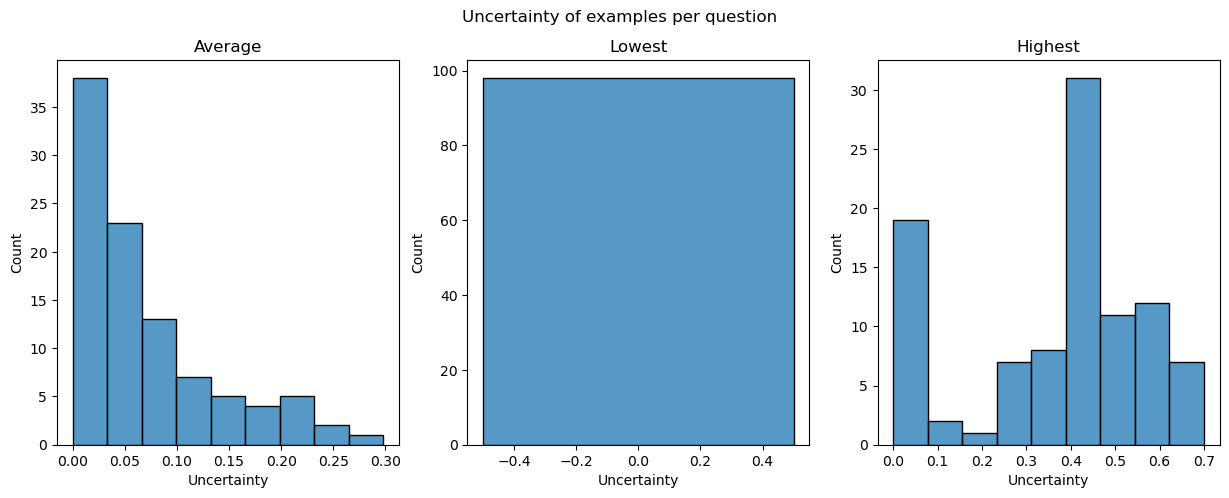

In [98]:
# plot the average, lowest, and highest uncertainty

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Uncertainty of examples per question")

sns.histplot(
    data=example_df,
    x="average_uncertainty",
    ax=axes[0]
)
axes[0].set_title("Average")
axes[0].set_xlabel("Uncertainty")

sns.histplot(
    data=example_df,
    x="lowest_uncertainty",
    ax=axes[1]
)
axes[1].set_title("Lowest")
axes[1].set_xlabel("Uncertainty")

sns.histplot(
    data=example_df,
    x="highest_uncertainty",
    ax=axes[2]
)
axes[2].set_title("Highest")
axes[2].set_xlabel("Uncertainty")

plt.show()


In [99]:
save_example_data_json(example_df, save_path=EXAMPLE_SAVE_PATH)

Saved 98 examples to: ../data/gpt-35-turbo_2023-08-06-09-43-35_examples-98_main_example_set.json


### Add Context to Best Example

In [100]:
sample_question = example_df.iloc[0]["best_example"]["example_question"]
print(sample_question)

Will the government of Colombia and the FARC renegotiate a peace agreement before 1 March 2017?


In [101]:
for idx, row in tqdm(example_df.iterrows(), total=example_df.shape[0]):
    best_example = row["best_example"]
    best_example_question = best_example["example_question"]

    error_count = 0
    try:
        context_result = get_background_research(
            best_example_question,
            chat=context_chat,
            prompt=context_chat_prompt,
        )
    except Exception as e:
        error_count += 1
        print(f"Error count: {error_count}")
        print(e)
        context_result = ""
    
    best_example["example_context"] = context_result

100%|██████████| 98/98 [23:10<00:00, 14.19s/it]


In [102]:
example_df.head(3)

,id,question,examples,best_example,lowest_uncertainty,highest_uncertainty,average_uncertainty
0,G2124,Will there be a complex coordinated terrorist ...,[{'example_question': 'Between 1 January 2018 ...,{'example_question': 'Will the government of C...,0.0,0.45,0.082
1,G2125,"Before 1 September 2022, will Egypt, Ethiopia,...",[{'example_question': 'Will the EU amend its O...,{'example_question': 'Will either Turkey or Ru...,0.0,0.50,0.104
2,G2141,"Before 1 January 2023, will the Taipei Economi...",[{'example_question': 'Between 18 October and ...,{'example_question': 'Will the New START treat...,0.0,0.35,0.040


In [103]:
save_example_data_json(example_df, save_path=EXAMPLE_SAVE_PATH)

Saved 98 examples to: ../data/gpt-35-turbo_2023-08-06-09-43-35_examples-98_main_example_set.json


### Update Test Dataframe

In [105]:
test_df = test_df.merge(
    example_df,
    on=["id", "question"]
)

test_df.head(3)

,question,id,background,publish_time,close_time,tags,source_links,prediction_count,forecaster_count,answer,...,majority_pred,pred_taken,acceptable_pred_lower_boundary,acceptable_pred_upper_boundary,context,examples,best_example,lowest_uncertainty,highest_uncertainty,average_uncertainty
0,Will there be a complex coordinated terrorist ...,G2124,CCTAs are a major concern for law enforcement ...,2021-09-17 15:49:41.402000+00:00,2022-09-01 07:01:00+00:00,"[Society, Security and Conflict]",[],340.0,111,None,...,0.05,0.05,-0.15,0.25,Entities:\n- Complex coordinated terrorist att...,[{'example_question': 'Between 1 January 2018 ...,{'example_question': 'Will the government of C...,0.0,0.45,0.082
1,"Before 1 September 2022, will Egypt, Ethiopia,...",G2125,"Tensions between Egypt, Ethiopia, and Sudan co...",2021-09-17 15:49:44.237000+00:00,2022-09-01 07:01:00+00:00,"[Foreign Policy, Security and Conflict, Non-US...",[https://www.securitycouncilreport.org/whatsin...,166.0,59,None,...,0.05,0.05,-0.15,0.25,"Entities:\n- Egypt: a country in North Africa,...",[{'example_question': 'Will the EU amend its O...,{'example_question': 'Will either Turkey or Ru...,0.0,0.50,0.104
2,"Before 1 January 2023, will the Taipei Economi...",G2141,Recent media reporting indicates discussions r...,2021-09-30 14:38:57.362000+00:00,2023-01-01 08:01:00+00:00,"[Foreign Policy, US Politics, Security and Con...",[],188.0,51,None,...,0.16,0.16,-0.04,0.36,Entities:\n- Taipei Economic and Cultural Repr...,[{'example_question': 'Between 18 October and ...,{'example_question': 'Will the New START treat...,0.0,0.35,0.040


In [106]:
test_df = test_df.drop_duplicates(subset=["id", "question"])

print(f"Test dataframe shape: {test_df.shape}")

Test dataframe shape: (98, 26)


In [107]:
save_test_df(test_df, TEST_DATA_FILE_NAME, DATA_DIR)

Saved test dataframe to: ../data/test_df-2023-08-06-07-42-24-size_98-filtered_test_data.json


## Add External Context

Add context from pre-made external dataframe.

In [115]:
external_context_path = "../results/GR_0.3_all_forecasts_baseline_df_20230727.csv"
external_context_df = pd.read_csv(external_context_path, index_col=0)

In [116]:
print(f"Shape of external context data: {external_context_df.shape}")

Shape of external context data: (98, 9)


In [117]:
external_context_df.head()

,question,qtype,choices_clean,answer,avg_forecast,crowd,question_context,LLM_answers,LLM_answers_clean
id,,,,,,,,,
G2124,Will there be a complex coordinated terrorist ...,t/f,"{'A': 'yes', 'B': 'no'}",NaN,B,[{'forecast': 0.05}],The United States remains in a heightened thre...,"['B - no.', 'B - no.', 'B - no.', 'B - no.', '...","['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', ..."
G2125,"Before 1 September 2022, will Egypt, Ethiopia,...",t/f,"{'A': 'yes', 'B': 'no'}",NaN,B,[{'forecast': 0.05}],"As of August 2021, the foreign ministers of Eg...","['A - yes.', 'A - yes.', 'A - yes.', 'A - yes....","['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', ..."
G2141,"Before 1 January 2023, will the Taipei Economi...",t/f,"{'A': 'yes', 'B': 'no'}",NaN,B,[{'forecast': 0.16}],The Taipei Economic and Cultural Representativ...,"['A - Yes.', 'A - yes.', 'A - yes', 'B - no.',...","['A', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'B', ..."
G2164,Will there be a lethal confrontation between t...,t/f,"{'A': 'yes', 'B': 'no'}",NaN,B,[{'forecast': 0.1}],The border dispute between India and China has...,"['B - no.', 'B - no.', 'B - no', 'B - no.', 'B...","['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', ..."
G2169,Will Taiwan publicly accuse the People's Repub...,t/f,"{'A': 'yes', 'B': 'no'}",NaN,B,[{'forecast': 0.3}],Taiwan and China have a long-standing conflict...,"['B - no.', 'B - no.', 'B - no', 'B - no.', 'B...","['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', ..."


In [119]:
sample_row_idx = 10
sample_question = external_context_df.iloc[sample_row_idx]["question"]
sample_external_context = external_context_df.iloc[sample_row_idx]["question_context"]

print("Question: ", sample_question)
print("")
print("External Context: ", sample_external_context)

Question:  Will Kassym-Jomart Tokayev either flee Kazakhstan or cease to be its president before 7 July 2022?

External Context:  Kassym-Jomart Tokayev is the current president of Kazakhstan, having taken office in 2019 after the resignation of Nursultan Nazarbayev. There have been recent riots in Kazakhstan due to the government's removal of fuel subsidies, but it is unclear whether or not Tokayev will flee or cease to be president before July 7, 2022.


In [123]:
external_context_df = external_context_df.reset_index()
external_context_df = external_context_df[['question_context', 'id']]
external_context_df.columns = ['external_context', 'id']
external_context_df.head()

,external_context,id
0,The United States remains in a heightened thre...,G2124
1,"As of August 2021, the foreign ministers of Eg...",G2125
2,The Taipei Economic and Cultural Representativ...,G2141
3,The border dispute between India and China has...,G2164
4,Taiwan and China have a long-standing conflict...,G2169


In [129]:
test_df = test_df.merge(
    external_context_df,
    on=["id"]
)

test_df.head(3)

,question,id,background,publish_time,close_time,tags,source_links,prediction_count,forecaster_count,answer,...,pred_taken,acceptable_pred_lower_boundary,acceptable_pred_upper_boundary,context,examples,best_example,lowest_uncertainty,highest_uncertainty,average_uncertainty,external_context
0,Will there be a complex coordinated terrorist ...,G2124,CCTAs are a major concern for law enforcement ...,2021-09-17 15:49:41.402000+00:00,2022-09-01 07:01:00+00:00,"[Society, Security and Conflict]",[],340.0,111,None,...,0.05,-0.15,0.25,Entities:\n- Complex coordinated terrorist att...,[{'example_question': 'Between 1 January 2018 ...,{'example_question': 'Will the government of C...,0.0,0.45,0.082,The United States remains in a heightened thre...
1,"Before 1 September 2022, will Egypt, Ethiopia,...",G2125,"Tensions between Egypt, Ethiopia, and Sudan co...",2021-09-17 15:49:44.237000+00:00,2022-09-01 07:01:00+00:00,"[Foreign Policy, Security and Conflict, Non-US...",[https://www.securitycouncilreport.org/whatsin...,166.0,59,None,...,0.05,-0.15,0.25,"Entities:\n- Egypt: a country in North Africa,...",[{'example_question': 'Will the EU amend its O...,{'example_question': 'Will either Turkey or Ru...,0.0,0.50,0.104,"As of August 2021, the foreign ministers of Eg..."
2,"Before 1 January 2023, will the Taipei Economi...",G2141,Recent media reporting indicates discussions r...,2021-09-30 14:38:57.362000+00:00,2023-01-01 08:01:00+00:00,"[Foreign Policy, US Politics, Security and Con...",[],188.0,51,None,...,0.16,-0.04,0.36,Entities:\n- Taipei Economic and Cultural Repr...,[{'example_question': 'Between 18 October and ...,{'example_question': 'Will the New START treat...,0.0,0.35,0.040,The Taipei Economic and Cultural Representativ...


In [130]:
save_test_df(test_df, TEST_DATA_FILE_NAME, DATA_DIR)

Saved test dataframe to: ../data/test_df-2023-08-06-07-42-24-size_98-filtered_test_data.json
